# Python for Creating CSV and Preliminary Reporting

In [1]:
import csv
import contextily as cx
import geopandas as gpd
import hvplot.pandas as hpd
import json
import matplotlib.pyplot as plt
import pandas as pd
import rdflib as rdf
from shapely.geometry import Point
import urllib



#import geopandas as gpd

%matplotlib inline
plt.style.use('ggplot')

from datetime import date
print("Last run: ", date.today())

#gv.extension('bokeh', 'matplotlib')

Last run:  2023-03-14


## Load Data and Write to CSV


In [2]:
with open("roman-amphitheaters.geojson") as f:
    j = json.load(f)

In [3]:
# If there is one, I'd welcome a more pythonic approach. One that 
# accomodates the variable data model supported by JSON.

d = []
for feature in j['features']:
    
    # Check for optional properties

    latintoponym = ''
    if 'latintoponym' in feature['properties'].keys():
        latintoponym = feature['properties']['latintoponym']
            
    welchid = ''
    if 'welchid' in feature['properties'].keys():
        welchid = feature['properties']['welchid']
        
    golvinid = ''
    if 'golvinid' in feature['properties'].keys():
        golvinid = feature['properties']['golvinid']

    buildingtype = ''
    if 'buildingtype' in feature['properties'].keys():
        buildingtype = feature['properties']['buildingtype']
            
    try:
        zotero = feature['properties']['bibliography'][0]['zoteroitem']
    except:
        zotero = ''
 
    chronogroup = ''
    if 'chronogroup' in feature['properties'].keys():
        chronogroup = feature['properties']['chronogroup']
        
    secondcentury = True
    if 'exclude' in feature['properties'].keys():
        secondcentury = False

    capacity = ''
    if 'capacity' in feature['properties'].keys():
        if 'quantity' in feature['properties']['capacity']:
            capacity = feature['properties']['capacity']['quantity']


    romanregion = ''
    if 'province' in feature['properties'].keys():
        romanregion = feature['properties']['province']
    elif 'region' in feature['properties'].keys():
        romanregion = feature['properties']['region']
        
        
    arenamajor = ''
    arenaminor = ''
    extmajor = ''
    extminor = ''
    exteriorheight = ''
    dimensionsunknown = True
    if 'dimensions' in feature['properties'].keys():
        dimensions = feature['properties']['dimensions']
        
        if 'arenamajor' in dimensions:
            if type(dimensions['arenamajor']) == int or type(dimensions['arenamajor']) == float:
                arenamajor = dimensions['arenamajor']
                dimensionsunknown = False

        if 'arenaminor' in dimensions:
            if type(dimensions['arenaminor']) == int or type(dimensions['arenaminor']) == float:
                arenaminor = dimensions['arenaminor']
                dimensionsunknown = False
            
        if 'exteriormajor' in dimensions:
            if type(dimensions['exteriormajor']) == int or type(dimensions['exteriormajor']) == float:
                extmajor = dimensions['exteriormajor']
                dimensionsunknown = False

        if 'exteriorminor' in dimensions:
            if type(dimensions['exteriorminor']) == int or type(dimensions['exteriorminor']) == float:
                extminor = dimensions['exteriorminor']
                dimensionsunknown = False
            
        if 'exteriorheight' in dimensions:
            if type(dimensions['exteriorheight']) == int or type(dimensions['exteriorheight']) == float:
                exteriorheight = dimensions['exteriorheight']
      
    d.append((feature['id'],
              feature['properties']['title'],
              feature['properties']['label'],
              latintoponym,
              feature['properties']['pleiades'],
              welchid,
              golvinid,
              buildingtype,
              chronogroup,
              secondcentury,
              capacity,
              feature['properties']['moderncountry'],
              romanregion,
              zotero,
              dimensionsunknown,
              arenamajor,
              arenaminor,
              extmajor,
              extminor,
              exteriorheight,
              feature['geometry']['coordinates'][0],
              feature['geometry']['coordinates'][1],
              feature['geometry']['coordinates'][2]))

ramphs_df = pd.DataFrame(d, columns=(
 'id',    # short id
 'title', # longer title
 'label', # short label
 'latintoponym', # latin toponym
 'pleiades', # pleiades https uri
 'welchid',  # id in Welch
 'golvinid', # id in Golvin
 'buildingtype',  # usually 'amphitheater'
 'chronogroup',   # label for the chronological group
 'secondcentury', # is this an amphitheater that was in use in 2nd century
 'capacity',    # capacity as integer
 'modcountry',  # modern country
 'romanregion', # province or augustan region of italy
 'zotero',      # zotero item id
 'dimensionsunknown', # if true, that's a direct statement that no dimensions are available
 'arenamajor', # long axis of arena in meters
 'arenaminor', # short axis of arena in meters
 'extmajor',   # long axis of exterior
 'extminor', # short axis of exterior
 'exteriorheight',   # height of exterior wall if known
 'longitude', # longitude
 'latitude', # latitude
 'elevation'  # elevation in meters.
 )) 

ramphs_df[['capacity','elevation','arenamajor','arenaminor',
        'extmajor','extminor','exteriorheight']] = ramphs_df[['capacity','elevation','arenamajor',
        'arenaminor','extmajor','extminor','exteriorheight']].apply(pd.to_numeric)

In [4]:
ramphs_df.to_csv("roman-amphitheaters.csv", index = False, quoting = csv.QUOTE_NONNUMERIC)

In [5]:
ramphs_df[['id','longitude','latitude']].to_csv("ll.csv", index = False, quoting = csv.QUOTE_NONNUMERIC)

## Basic Mapping

Skipping field comment: unsupported OGR type: 5
Skipping field dedication: unsupported OGR type: 5
Skipping field see: unsupported OGR type: 5
Skipping field wikipedia: unsupported OGR type: 5
Skipping field youtube: unsupported OGR type: 5


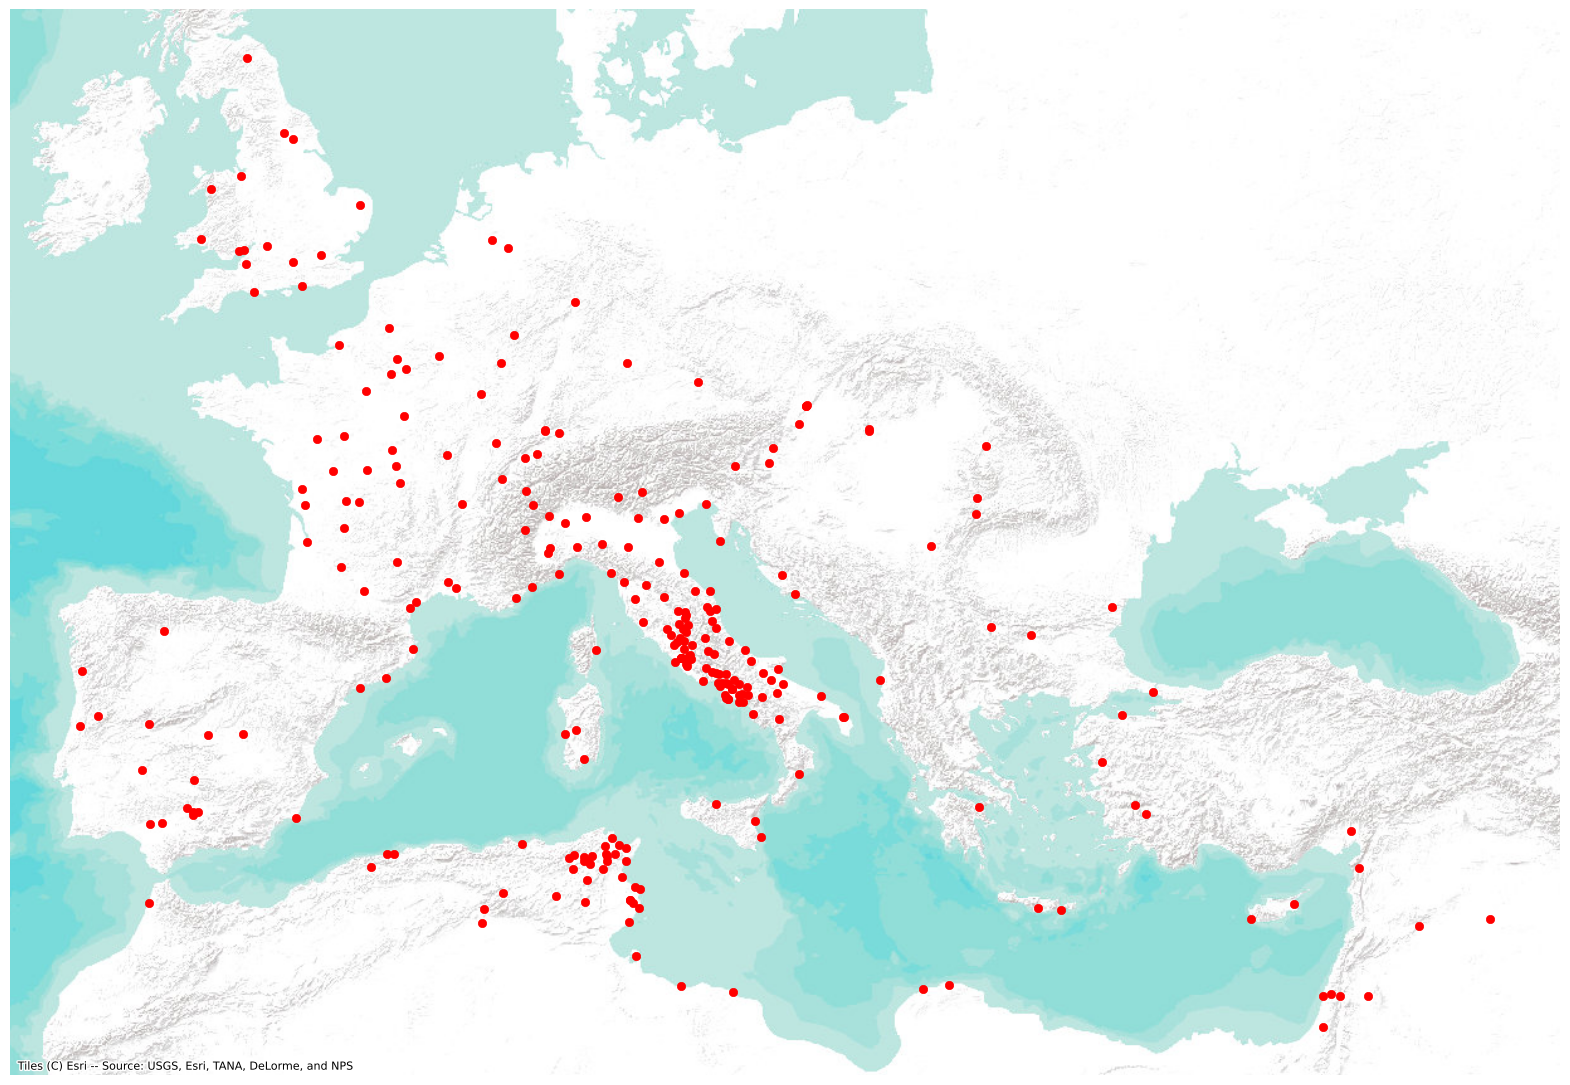

In [6]:
ramphs_gdf = gpd.read_file("roman-amphitheaters.geojson")

ramphs_gdf_epsg3857 = ramphs_gdf.to_crs(3857)

ax = ramphs_gdf_epsg3857.plot(figsize=(20, 20), color = 'red')
cx.add_basemap(ax, source=cx.providers.Esri.WorldTerrain)

ax.set_axis_off()
plt.savefig("all-roman-amphitheaters-map.png",pad_inches=0, bbox_inches='tight')

In [7]:
# interactive version
tb = ramphs_gdf_epsg3857.total_bounds

hv = ramphs_gdf_epsg3857.hvplot(global_extent=False,
                          
                           hover_cols = ['id'],
                           tiles='EsriTerrain',
                           xticks = 0, yticks = 0,
                           xlim = (tb[0]-300000,tb[2]),
                           ylim = (tb[1]-300000,tb[3]+300000),
                           height = 500,
                           width = 700,
                                c = 'red'
                           )


hv

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [x,y]   (id)

In [8]:
# with roman territory using geopandas


url = "http://sebastianheath.com/roman-maps/roman_empire_ad_200_extent.geojson" # at some point update geojson source
borders_gdf = gpd.read_file(url)

base = borders_gdf.plot(color = 'black', figsize = (40,24))
ramphs_gdf.plot(ax = base, color = 'red', markersize = 100)

plt.grid(False)
plt.axis('off')

plt.savefig('all-roman-amphitheaters-map-dark.png',pad_inches=0, bbox_inches='tight', transparent = True)
plt.close()

## Basic/Various Reporting

This is semi-random / redundant code by which I keep on top of data entry...

In [9]:
ramphs_df.head(2)

id                         title  label  latintoponym  \
0  duraEuroposAmphitheater  Amphitheater at Dura Europos   Dura  Dura Europus   
1        arlesAmphitheater         Amphitheater at Arles  Arles       Arelate   

                                  pleiades welchid golvinid  buildingtype  \
0  https://pleiades.stoa.org/places/893989              129  amphitheater   
1  https://pleiades.stoa.org/places/148217              154  amphitheater   

  chronogroup  secondcentury  ...    zotero dimensionsunknown arenamajor  \
0     severan          False  ...  5ADZC245             False       31.0   
1     flavian           True  ...  LD7NNHSG             False       47.0   

  arenaminor  extmajor  extminor  exteriorheight  longitude   latitude  \
0       25.0      50.0      44.0             NaN  40.728926  34.749855   
1       32.0     136.0     107.0             NaN   4.631111  43.677778   

   elevation  
0        223  
1         21  

[2 rows x 23 columns]

In [10]:
ramphs_df.describe()

capacity  arenamajor  arenaminor    extmajor    extminor  \
count    152.000000  182.000000  178.000000  215.000000  197.000000   
mean   12473.618421   56.802527   38.439775   96.292465   77.582030   
std     9130.110172   14.209024    8.793810   30.632660   25.213482   
min     1000.000000   25.000000   19.000000   25.000000   31.000000   
25%     5723.250000   47.000000   32.175000   74.250000   59.400000   
50%    10000.000000   58.000000   39.000000   93.000000   75.000000   
75%    17025.000000   66.000000   43.000000  114.500000   94.500000   
max    50000.000000  104.000000   74.000000  189.000000  156.000000   

       exteriorheight   longitude    latitude    elevation  
count        3.000000  271.000000  271.000000   271.000000  
mean        41.483333   10.589693   42.245760   197.380074  
std          9.859048    9.015660    4.914164   211.323044  
min         32.450000   -8.493330   31.608189  -121.000000  
25%         36.225000    5.506932   38.726360    34.500000  
50%         40.000000   10.994350   42.100889   122.000000  
75%         46.000000   14.150271   45.532837   289.000000  
max         52.000000   40.728926   55.602600  1170.000000

In [11]:
ramphs_df[ramphs_df.secondcentury].describe()

capacity  arenamajor  arenaminor    extmajor    extminor  \
count    142.000000  172.000000  168.000000  203.000000  187.000000   
mean   12298.253521   56.850640   38.582024   96.090542   77.568770   
std     9071.869226   14.326077    8.879051   29.594578   25.049908   
min     1248.000000   25.000000   19.000000   25.000000   31.000000   
25%     5507.750000   46.950000   32.525000   74.750000   59.700000   
50%     9885.000000   58.000000   39.100000   92.800000   75.000000   
75%    16036.750000   66.000000   43.050000  113.850000   94.250000   
max    50000.000000  104.000000   74.000000  189.000000  156.000000   

       exteriorheight   longitude    latitude    elevation  
count        2.000000  249.000000  249.000000   249.000000  
mean        42.225000   10.077572   42.356509   197.783133  
std         13.823938    8.806989    4.962132   211.534184  
min         32.450000   -8.493330   31.608189     1.000000  
25%         37.337500    4.310856   38.806888    35.000000  
50%         42.225000   10.629951   42.302681   125.000000  
75%         47.112500   14.046835   45.740914   288.000000  
max         52.000000   38.273763   55.602600  1170.000000

In [12]:
# Confirm that CSV is readable
# It would be nice if the "numeric pattern" string survived as strings.
pd.read_csv("roman-amphitheaters.csv", quoting = 2).describe()

welchid    golvinid      capacity  arenamajor  arenaminor  \
count  19.000000  166.000000    152.000000  182.000000  178.000000   
mean   10.105263  100.578313  12473.618421   56.802527   38.439775   
std     5.724166   58.199369   9130.110172   14.209024    8.793810   
min     1.000000    2.000000   1000.000000   25.000000   19.000000   
25%     5.500000   54.250000   5723.250000   47.000000   32.175000   
50%    10.000000  103.500000  10000.000000   58.000000   39.000000   
75%    15.500000  145.750000  17025.000000   66.000000   43.000000   
max    19.000000  298.000000  50000.000000  104.000000   74.000000   

         extmajor    extminor  exteriorheight   longitude    latitude  \
count  215.000000  197.000000        3.000000  271.000000  271.000000   
mean    96.292465   77.582030       41.483333   10.589693   42.245760   
std     30.632660   25.213482        9.859048    9.015660    4.914164   
min     25.000000   31.000000       32.450000   -8.493330   31.608189   
25%     74.250000   59.400000       36.225000    5.506932   38.726360   
50%     93.000000   75.000000       40.000000   10.994350   42.100889   
75%    114.500000   94.500000       46.000000   14.150271   45.532837   
max    189.000000  156.000000       52.000000   40.728926   55.602600   

         elevation  
count   271.000000  
mean    197.380074  
std     211.323044  
min    -121.000000  
25%      34.500000  
50%     122.000000  
75%     289.000000  
max    1170.000000

In [13]:
# which have heights
ramphs_df[ramphs_df.exteriorheight > 0]

id                         title           label  \
4   romeFlavianAmphitheater  Flavian Amphitheater at Rome       Colosseum   
91     thysdrusAmphitheater      Amphitheater at Thysdrus  Thysdrus (lg.)   
98         pulaAmphitheater          Amphitheater at Pula            Pula   

                                      latintoponym  \
4                                                    
91                                                   
98  Colonia Pietas Iulia Pola Pollentia Herculanea   

                                   pleiades welchid golvinid  buildingtype  \
4   https://pleiades.stoa.org/places/423025              152  amphitheater   
91  https://pleiades.stoa.org/places/324835              186  amphitheater   
98  https://pleiades.stoa.org/places/197448              151  amphitheater   

       chronogroup  secondcentury  ...    zotero dimensionsunknown arenamajor  \
4          flavian           True  ...  VKMRD8AT             False      83.00   
91    post-severan          False  ...                       False      65.00   
98  julio-claudian           True  ...                       False      67.95   

   arenaminor  extmajor  extminor  exteriorheight  longitude   latitude  \
4       48.00    189.00     156.0           52.00  12.492269  41.890169   
91      39.00    148.00     122.0           40.00  10.706939  35.296390   
98      41.65    132.45     105.1           32.45  13.850243  44.873229   

    elevation  
4          22  
91        111  
98         16  

[3 rows x 23 columns]

In [14]:
# which don't have exteriormajor
ramphs_df[pd.isnull(ramphs_df.extmajor)].sort_values(by = 'longitude')\
[['id','modcountry','latintoponym','golvinid','extmajor','arenamajor','latitude','longitude']]

id      modcountry  \
158                        bragaAmphitheater        Portugal   
168                     bobadelaAmphitheater        Portugal   
56                         lixusAmphitheater         Morocco   
122                      caparraAmphitheater           Spain   
196                       espejoAmphitheater           Spain   
159                       sisapoAmphitheater           Spain   
269                       toledoAmphitheater           Spain   
69                    aldburoughAmphitheater  United Kingdom   
257                         yorkAmphitheater  United Kingdom   
260                   chichesterAmphitheater  United Kingdom   
46                        gennesAmphitheater          France   
144                         agenAmphitheater          France   
184                    chassenonAmphitheater          France   
151              caistorStEdmundAmphitheater  United Kingdom   
148                     chartresAmphitheater          France   
37                         parisAmphitheater          France   
205           montbouyGalloRomanAmphitheater          France   
147                        meauxAmphitheater          France   
208                  mesarafeltaAmphitheater         Algeria   
20                      nijmegenAmphitheater     Netherlands   
63   hydataHypsitanaForumTraianiAmphitheater           Italy   
194                     tebourbaAmphitheater         Tunisia   
210                       carpisAmphitheater         Tunisia   
201                       pupputAmphitheater         Tunisia   
261                 reggioEmiliaAmphitheater           Italy   
265                       trentoAmphitheater           Italy   
167                      perugiaAmphitheater           Italy   
206              statiliusTaurusAmphitheater           Italy   
3                           ludusMagnusArena           Italy   
228                   forumNovumAmphitheater           Italy   
84                        assisiAmphitheater           Italy   
136                   monteleoneAmphitheater           Italy   
236                        fermoAmphitheater           Italy   
254                 suessaAruncaAmphitheater           Italy   
154                      liternoAmphitheater           Italy   
243                        teanoAmphitheater           Italy   
13                 pozzuoliEarlyAmphitheater           Italy   
242                       chietiAmphitheater           Italy   
140                    beneventoAmphitheater           Italy   
255                   altripaldaAmphitheater           Italy   
256                       compsaAmphitheater           Italy   
174                    gleisdorfAmphitheater         Austria   
241                      sipontoAmphitheater           Italy   
22                            carnuntumLudus         Austria   
239                      egnaziaAmphitheater           Italy   
39                        cyreneAmphitheater           Libya   
119                       sophiaAmphitheater        Bulgaria   
207                      hisaryaAmphitheater        Bulgaria   
264                      nazilliAmphitheater          Turkey   
224                        geyreAmphitheater          Turkey   
259                     istanbulAmphitheater          Turkey   
106                      salamisAmphitheater          Cyprus   
100                     caesareaAmphitheater          Israel   
47               scythopolisNysaAmphitheater          Israel   
103                      antiochAmphitheater          Turkey   
177                      palmyraAmphitheater           Syria   

                     latintoponym golvinid  extmajor  arenamajor   latitude  \
158               Bracara Augusta                NaN         NaN  41.546669   
168                     Elbocoris                NaN        50.0  40.361088   
56                          Lixus                NaN        34.0  35.199900   
122  Municipium Flavium Caparense                NaN        30.0  40.164159  

In [15]:
ramphs_df[ramphs_df.golvinid == '' ][['id','latintoponym','golvinid','extmajor','arenamajor','latitude','longitude']]

id          latintoponym golvinid  extmajor  \
3              ludusMagnusArena          Ludus Magnus                NaN   
6    eleutheropolisAmphitheater        Eleutheropolis               71.0   
9          newsteadAmphitheater            Trimontium               70.0   
11            cumaeAmphitheater                 Cumae              114.0   
16     hadrianVillaAmphitheater        Villa Hadriani               25.0   
..                          ...                   ...      ...       ...   
263  torreparedonesAmphitheater  Colonia Virtus Iulia               69.0   
264         nazilliAmphitheater              Mastaura                NaN   
265          trentoAmphitheater             Tridentum                NaN   
269          toledoAmphitheater               Toletum                NaN   
270    kaiseraugustAmphitheater    Castrum Rauracense               50.0   

     arenamajor   latitude  longitude  
3           NaN  41.889950  12.494913  
6          47.0  31.608189  34.893845  
9          37.0  55.602600  -2.691900  
11          NaN  40.841847  14.056000  
16          NaN  41.941640  12.778916  
..          ...        ...        ...  
263         NaN  37.752468  -4.380600  
264         NaN  37.955596  28.338099  
265        62.0  46.069205  11.125334  
269         NaN  39.865349  -4.022888  
270         NaN  47.540822   7.721596  

[105 rows x 7 columns]

In [16]:
ramphs_df[ramphs_df.latintoponym == '' ][['id','latintoponym','golvinid','extmajor','arenamajor','latitude','longitude']]

id latintoponym golvinid  \
4                        romeFlavianAmphitheater                   152   
5                     romeAmphitheatrumCastrense                   189   
19                        porolissumAmphitheater                    39   
28                           italicaAmphitheater                   168   
34                        viminaciumAmphitheater                         
35                       flaviaSolvaAmphitheater                    52   
38   octodurusForumClaudiiVallensiumAmphitheater                    27   
44                      charterhouseAmphitheater                    32   
47                   scythopolisNysaAmphitheater                         
52                           virunumAmphitheater                    51   
61                           allifaeAmphitheater                         
63       hydataHypsitanaForumTraianiAmphitheater                         
77                            salonaAmphitheater                   181   
79                             tiburAmphitheater                         
86                         lambaesisAmphitheater                   111   
87                          mactarisAmphitheater                   119   
89                        vindonissaAmphitheater                    17   
90                     thysdrusSmallAmphitheater                   112   
91                          thysdrusAmphitheater                   186   
93                            gortynAmphitheater                         
94                        leptiminusAmphitheater                   114   
95                             miciaAmphitheater                    47   
96                          gemellaeAmphitheater                    44   
97                         cherchellAmphitheater                    81   
100                         caesareaAmphitheater                         
102                        anazarbusAmphitheater                         
103                          antiochAmphitheater                         
104                          cyzicusAmphitheater                         
105                         sabrathaAmphitheater                   120   
106                          salamisAmphitheater                         
107                           paphosAmphitheater                         
110                      tomen-y-murAmphitheater                    31   
111                          thaenaeAmphitheater                    71   
117                          bararusAmphitheater                   187   
118                     castraAlbanaAmphitheater                   190   
120                        ptolemaisAmphitheater                    76   
159                           sisapoAmphitheater                         
163                         arnsburgAmphitheater                         
164                        ierapetraAmphitheater                         
172                          dambachAmphitheater                         
174                        gleisdorfAmphitheater                         
177                          palmyraAmphitheater                         
190                   genzanoPrivateAmphitheater                         
205               montbouyGalloRomanAmphitheater                         
206                  statiliusTaurusAmphitheater                         
226                                zagaroloLudus                         
227                         tusculumAmphitheater                   184   
234                      jebelMorabaAmphitheater                         
268               saintGeorgesDuBoisAmphitheater                   103   

     extmajor  arenamajor   latitude  longitude  
4       189.0       83.00  41.890169  12.492269  
5        88.0         NaN  41.887715  12.515144  
19       84.0       64.00  47.177552  23.154052  
28      160.0       70.00  37.443893  -6.046742  
34       84.0       55.00  44.737985  21.220083  
35       97.0       85.00  46.767153  15.5657

## Duplicate Checking

In [17]:
dups = ramphs_df[ramphs_df.label.duplicated(keep = False)]\
[['id','pleiades','latintoponym','latitude','longitude']].sort_values('pleiades')

len(dups) == 0

True

In [18]:
dups = ramphs_df[ramphs_df.id.duplicated(keep = False)]\
[['id','pleiades','latintoponym','latitude','longitude']].sort_values('pleiades')

len(dups) == 0

True

In [19]:
dups = ramphs_df[ramphs_df.pleiades.duplicated(keep = False)]\
[['id','pleiades','latintoponym','latitude','longitude']].sort_values('pleiades')

len(dups) == 15

False

In [20]:
dups = ramphs_df[ramphs_df.latintoponym.duplicated(keep = False)]\
[['id','pleiades','latintoponym',
  'latitude','longitude']].sort_values('pleiades')

len(dups.query("latintoponym != ''")) == 11

True

# Chronogrps

In [21]:
c_grps_from_j = j['romanamphitheaterschronogroups']

In [22]:
c_grps_to_csv = [[g['id'],g['startdate'],g['enddate']] for g in c_grps_from_j]

In [23]:
print(f"In c_grps, not in data: {set([i[0] for i in c_grps_to_csv]) - set([i[8] for i in d])}")
print(f"In data, not in c_grps: {set([i[8] for i in d]) - set([i[0] for i in c_grps_to_csv])}")

In c_grps, not in data: set()
In data, not in c_grps: set()


In [24]:
if (set([i[0] for i in c_grps_to_csv]) == set([i[8] for i in d])):
    c_grps_df = pd.DataFrame(c_grps_to_csv, columns = ('id','startdate','enddate'))
    c_grps_df.to_csv("chronogrps.csv", index = False, quoting = csv.QUOTE_NONNUMERIC)

In [25]:
# Provinces (new, incomplete)

# Golvin ID

In [26]:
L = ramphs_df[ramphs_df['golvinid'] != '']['golvinid'].astype(int).sort_values().tolist()
missingItems = [x for x in list(range(300)) if not x in L]
missingItems

[0,
 1,
 18,
 25,
 28,
 29,
 30,
 36,
 37,
 43,
 48,
 49,
 50,
 60,
 63,
 68,
 85,
 89,
 94,
 95,
 96,
 134,
 150,
 169,
 173,
 175,
 176,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 212,
 213,
 214,
 215,
 216,
 217,
 218,
 219,
 220,
 221,
 222,
 223,
 224,
 225,
 226,
 227,
 228,
 229,
 230,
 231,
 232,
 233,
 234,
 235,
 236,
 237,
 238,
 239,
 240,
 241,
 242,
 243,
 244,
 245,
 246,
 247,
 248,
 249,
 250,
 251,
 252,
 253,
 254,
 255,
 256,
 257,
 258,
 259,
 260,
 261,
 262,
 263,
 264,
 265,
 266,
 267,
 268,
 269,
 270,
 271,
 272,
 273,
 275,
 276,
 277,
 278,
 279,
 280,
 281,
 282,
 283,
 284,
 285,
 286,
 287,
 288,
 289,
 290,
 291,
 292,
 293,
 294,
 295,
 296,
 297,
 299]

### Dimension/Capacity Combos

False


/var/folders/0y/3pzj87t12_9_lfsmt62vt17m0000gn/T/ipykernel_7368/464804493.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  ramphs_df.loc[ramphs_df[['extmajor','extminor','arenamajor','arenaminor']].notnull().any(1) & ramphs_df['capacity'].isnull(),'displaycolor'] = 'yellow' # any dim, no cap


<AxesSubplot: >

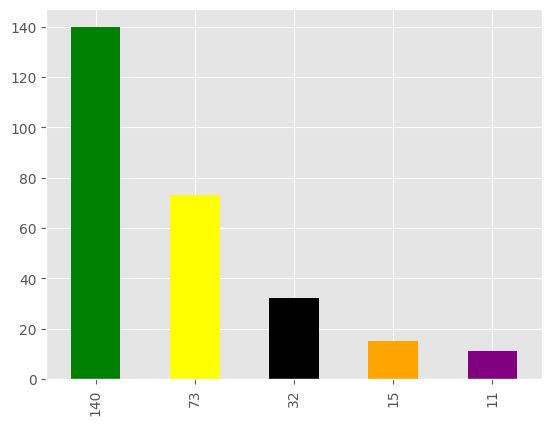

In [27]:
ramphs_df['displaycolor'] = 'red' # problem

ramphs_df.loc[ramphs_df[['capacity']].notnull().all(1),'displaycolor'] = 'purple' # any capacity
ramphs_df.loc[ramphs_df[['extmajor','extminor','arenamajor','arenaminor','capacity']].notnull().all(1),'displaycolor'] = 'green' # 4 dims, cap, complete

ramphs_df.loc[ramphs_df[['extmajor','extminor','arenamajor','arenaminor']].notnull().any(1) & ramphs_df['capacity'].isnull(),'displaycolor'] = 'yellow' # any dim, no cap
ramphs_df.loc[ramphs_df[['extmajor','extminor','arenamajor','arenaminor']].notnull().all(1) & ramphs_df['capacity'].isnull(),'displaycolor'] = 'orange' # 4 dims, no cap

ramphs_df.loc[ramphs_df['dimensionsunknown'] == True,'displaycolor'] = 'black' # no dims, might be a cap 'nazili'

# this should be False
print('red' in list(ramphs_df.displaycolor.unique()))

bar_series = ramphs_df['displaycolor'].value_counts()

bar_series.index = ramphs_df['displaycolor'].value_counts()


bar_series.plot.bar(color = ramphs_df['displaycolor'].value_counts().index, xlabel = '')

In [28]:
# 4 dims, no 3rd party capacity estimate yet entered
all_ok = ['allifaeAmphitheater','altinumAmphitheater','anazarbusAmphitheater','avellaAmphitheater',
          'burnumAmphitheater', 'carmarthenAmphitheater',
          'cherchellAmphitheater','larinoAmphitheater','leonAmphitheater',
          'porolissumAmphitheater', 'narbonneAmphitheater','tharrosAmphitheater']

ramphs_df.loc[ramphs_df[['extmajor','extminor','arenamajor','arenaminor']]\
              .notnull().all(1) & ramphs_df['capacity'].isnull()\
              ,['id','golvinid','capacity','dimensionsunknown']]\
              .set_index('id', drop=False)\
              .drop(all_ok)# .hvplot.table(sortable=True, selectable=True)


id golvinid  capacity  \
id                                                                      
charterhouseAmphitheater  charterhouseAmphitheater       32       NaN   
florenceAmphitheater          florenceAmphitheater      140       NaN   
suasaAmphitheater                suasaAmphitheater                NaN   

                          dimensionsunknown  
id                                           
charterhouseAmphitheater              False  
florenceAmphitheater                  False  
suasaAmphitheater                     False

In [29]:
# fewer than 4 dims, capacity recorded
ramphs_df.loc[ramphs_df['displaycolor'] == 'purple'\
              ,['id','golvinid','capacity','dimensionsunknown','extmajor','extminor','arenamajor','arenaminor']]\
            .hvplot.table(sortable=True, selectable=True)


:Table   [id,golvinid,capacity,dimensionsunknown,extmajor,extminor,arenamajor,arenaminor]

In [30]:
# any dim, no cap
# ok_to_drop

ramphs_df.loc[ramphs_df['displaycolor'] == 'yellow'\
              ,['id','golvinid','capacity','dimensionsunknown','extmajor','extminor','arenamajor','arenaminor']]\
            .hvplot.table(sortable=True, selectable=True)

:Table   [id,golvinid,capacity,dimensionsunknown,extmajor,extminor,arenamajor,arenaminor]